# This file is to collect the data, compare and storing it in csv files
- step 1 : collecting the 20 text classification and text generation models data ( name ,type ,updated date, downloaded , liked)
- step 2 : collecting the app counts associated with the models obtained in the step 1 and compare them
- step 3 : collecting the source code size of the apps found in the step 3 and compare them
- step 4 : clearning data ( duplicate removing )
- step 5 : Merging all the previously obtained data in to a single csv for each classification and generation model.
- step 6 : Give the analysis result
- step 7 : propose further what other analysis could be useful to add

### Importing the necessary libraries 

In [21]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import csv
import json
from time import sleep
import nest_asyncio
import asyncio
import aiohttp
import concurrent.futures
import ast

# Step 1: Obtaining 20 text classification and text generation models list

In [22]:
# Step 1: Obtain a list of the top-20 "Text Classification" models
# sorted and filterd based of most downloads

classification_url = "https://huggingface.co/models?pipeline_tag=text-classification&sort=downloads"
classification_models = []

#capturing the web response , response type html
response = requests.get(classification_url)
soup = BeautifulSoup(response.content, "html.parser")
model_list = soup.find_all("article", class_="overview-card-wrapper")

# collecting data for first 20 text classification models
for model in model_list[:20]:
    model_name = model.find("header", class_="flex items-center mb-0.5").text.strip()
    model_details  = model.find("div", class_="mr-1 flex items-center overflow-hidden whitespace-nowrap text-sm leading-tight text-gray-400").text.replace("\t","*").replace('\n', '*').replace('• ',"*").strip('').split("*")
    model_details =list(filter(bool, model_details))
    m_type= model_details[0]
    updated = model_details[2]
    downloaded= model_details[3]
    liked= model_details[4]
    dic = {
        "model_name": model_name,
        "model_type": m_type,
        "updated" : updated,
        "downloaded" : downloaded,
        "liked" : liked
    }
    # print(dic,end="\n")
    classification_models.append(dic)

In [23]:
# Obtain a list of the top-20 text generation models
# sorted and filterd based of most downloads

generation_url = "https://huggingface.co/models?pipeline_tag=text-generation&sort=downloads"
generation_models = []

#capturing the web response , response type html
response = requests.get(generation_url)
soup = BeautifulSoup(response.content, "html.parser")
model_list = soup.find_all("article", class_="overview-card-wrapper")

# collecting data for first 20 text generation models
for model in model_list[:20]:
    model_name = model.find("header", class_="flex items-center mb-0.5").text.strip()
    model_details  = model.find("div", class_="mr-1 flex items-center overflow-hidden whitespace-nowrap text-sm leading-tight text-gray-400").text.replace("\t","*").replace('\n', '*').replace('• ',"*").strip('').split("*")
    model_details =list(filter(bool, model_details))
    m_type= model_details[0]
    updated = model_details[2]
    downloaded= model_details[3]
    liked= model_details[4]
    dic = {
        "model_name": model_name,
        "model_type": m_type,
        "updated" : updated,
        "downloaded" : downloaded,
        "liked" : liked
    }
    # print(dic,end="\n")
    generation_models.append(dic)

### Creating a csv file from the data obtained from step 1

In [24]:
# Resuable function for saving data into csv format
# First load the list into a panda dataframe 
# then create a csv using pandas build in to_csv() method
def save_to_csv(data,filename):
    data_df=pd.DataFrame(data)
    data_df.to_csv(f"all_csv_data/{filename}",index=False)
    

In [25]:
save_to_csv(classification_models,"classification_models.csv")
save_to_csv(generation_models,"generation_models.csv")

# Step 2: Obtain and compare the number of ML apps ("spaces") for each "Text Classification" and "text generation" model

In [26]:
# function for finding the targeted element
def find_elements(html, parent_selector):
    soup = BeautifulSoup(html, 'html.parser')
    parent_tag = soup.select_one(parent_selector)
  
    temp={
    "linkedSpaces" : []
    }
    return parent_tag.get('data-props') if parent_tag is not None else json.dumps(temp)
  

In [27]:
nest_asyncio.apply()
# asynchronous network call to faster execution time and parallel task execution
async def fetch_linked_spaces(model_name, session):
    model_url = f"https://huggingface.co/{model_name['model_name']}"
    async with session.get(model_url) as response:
        data = []
        if response.status == 200:
            content = await response.text()
            soup = BeautifulSoup(content, "html.parser")
            linked_spaces = soup.find_all(attrs={"data-target": "LinkedSpacesList"})
            # print(linked_spaces)
            if linked_spaces:
                data = [item['id'] for item in json.loads(linked_spaces[0].get('data-props'))['linkedSpaces']]
                
        return {
            "model_name": model_name['model_name'],
            "model_url": model_url,
            "app_list": data,
            "total_app": len(data)
        }

async def get_app_count(models):
    async with aiohttp.ClientSession() as session:
        tasks = [fetch_linked_spaces(model_name, session) for model_name in models]
        app_count = await asyncio.gather(*tasks)
    return app_count

async def get_count_of_apps():
    class_app_count = await get_app_count(classification_models)
    gen_app_count = await get_app_count(generation_models)
    return class_app_count,gen_app_count

loop = asyncio.get_event_loop()
classification_app_count,generation_app_count = loop.run_until_complete(get_count_of_apps())

In [28]:
# creating csv for app_count
save_to_csv(classification_app_count,"classification_app_count.csv")
save_to_csv(generation_app_count,"generation_app_count.csv")

## Compared between text classification and text generation model based on step 2 (app count)

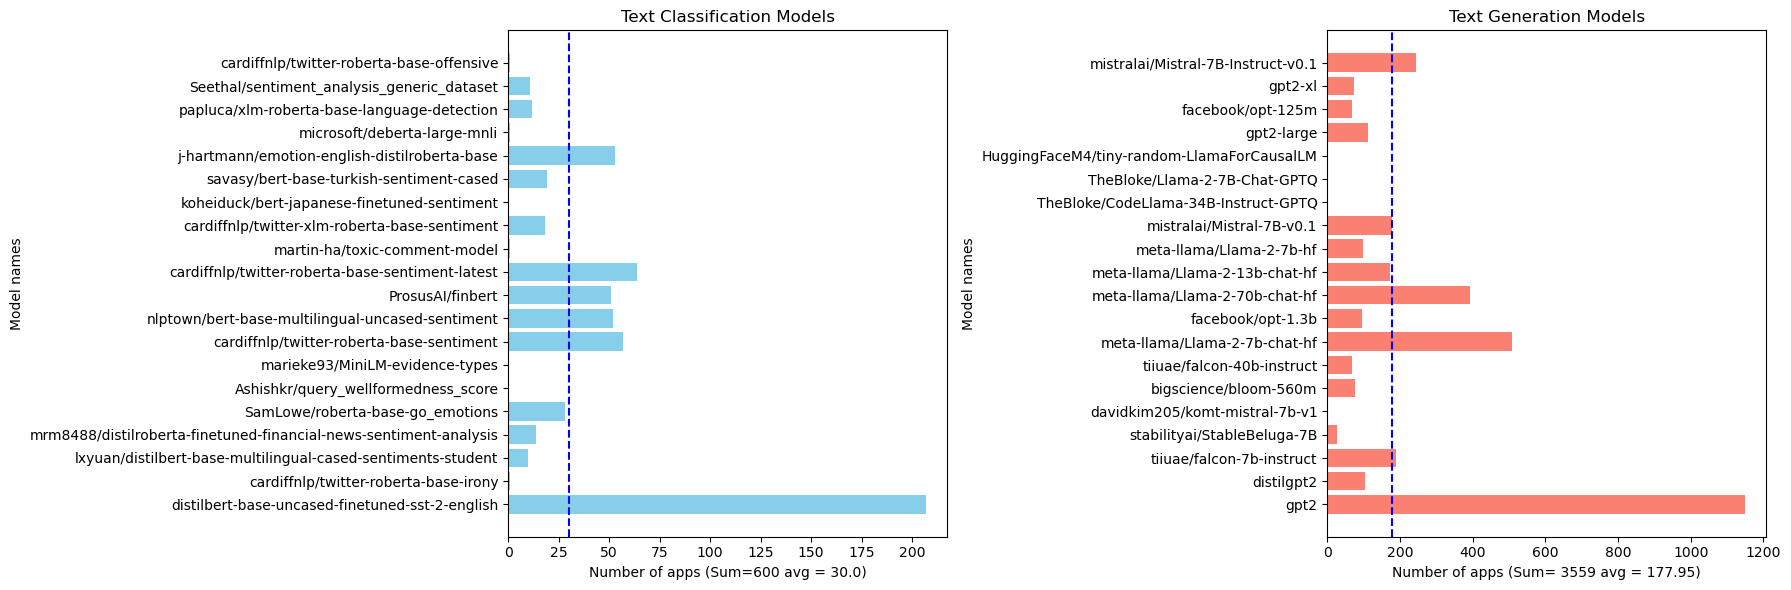

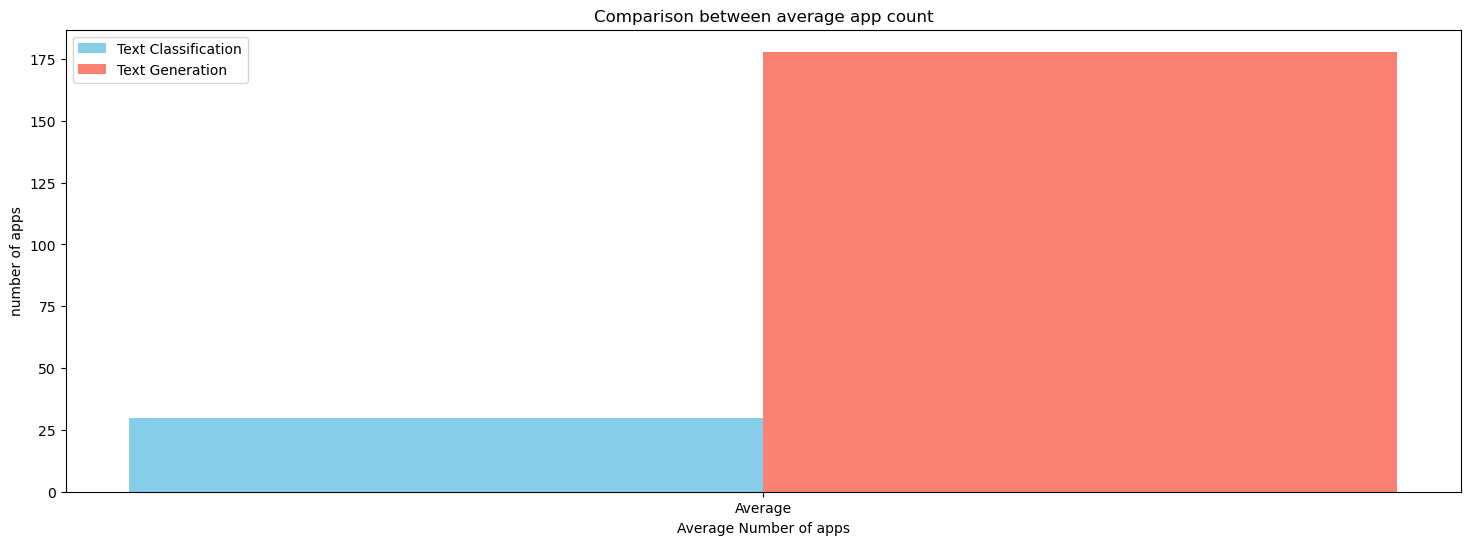

In [42]:
# Create DataFrames
df1 = pd.read_csv("all_csv_data/classification_app_count.csv")
df2 = pd.read_csv("all_csv_data/generation_app_count.csv")

#==========================================================
# Bar charts for apps count for models
#==========================================================

# Set the figure size
plt.figure(figsize=(18, 6))

# Plotting the first bar chart
plt.subplot(1, 2, 1)
plt.barh(df1["model_name"].values, df1["total_app"].values, color='skyblue')
average1 = sum(df1["total_app"].values) / len(df1["total_app"].values)

# average line marker
plt.axvline(average1, color='b', linestyle='--', label='Average')

plt.xlabel(f'Number of apps (Sum={sum(df1["total_app"].values)} avg = {average1})')
plt.ylabel(f'Model names')
plt.title('Text Classification Models')


# Plotting the second bar chart
plt.subplot(1, 2, 2)
plt.barh(df2["model_name"].values, df2["total_app"].values, color='salmon')
average2 = sum(df2["total_app"].values) / len(df2["total_app"].values)

#average line marker
plt.axvline(average2, color='b', linestyle='--', label='Average')

plt.xlabel(f'Number of apps (Sum= {sum(df2["total_app"].values)} avg = {average2})')
plt.ylabel(f'Model names')
plt.title('Text Generation Models')

# Adjust layout for better spacing
plt.tight_layout()

plt.savefig('plot_imgs/models_app_count.png')

#==========================================================
# plot for Comparison between average app count
#==========================================================

#  Grouped Bar Chart
labels = ['Average']

x = range(len(labels))
width = 0.35

fig, ax = plt.subplots( figsize=(18, 6))
rects1 = ax.bar(x, average1, width, label='Text Classification',color="skyblue")
rects2 = ax.bar([i + width for i in x], average2, width, label='Text Generation',color="salmon")

ax.set_xlabel('Average Number of apps')
ax.set_ylabel('number of apps')
ax.set_title('Comparison between average app count')
ax.set_xticks([i + width / 2 for i in x])
ax.set_xticklabels(labels)
ax.legend()
# Show the plot
plt.show()

fig.savefig('plot_imgs/models_avg_app_count.png')

# Step 3 :obtain and compare the source code size of the ML apps ("spaces") obtained in step 2 

In [30]:
# converting kb to bytes to store size in bytes
def kb_to_bytes(kb):
    s_bytes = kb * 1024
    return s_bytes

In [31]:
nest_asyncio.apply()
# asynchronous network call to faster execution time and parallel task execution
async def fetch_code_size(session, space):
    space_url = f"https://huggingface.co/spaces/{space}/tree/main"
    async with session.get(space_url) as response:
        space_soup = BeautifulSoup(await response.text(), "html.parser")
        file_download_selector = '[title="Download file"]'
        available_files = space_soup.select(file_download_selector)
        code_size = sum([float(file.text.split(" ")[0]) if file.text.split(" ")[1].strip() != "kB" else kb_to_bytes(float(file.text.split(" ")[0])) for file in available_files])
    return {"app_name": space, "size_in_bytes": code_size}

async def get_app_source_size(app_count):
    async with aiohttp.ClientSession() as session:
        tasks = [fetch_code_size(session, space) for x in app_count for space in x["app_list"]]
        app_source_size = await asyncio.gather(*tasks)
    return app_source_size


async def source_size_calc():
    class_app_sizes= await get_app_source_size(classification_app_count)
    gen_app_sizes = await get_app_source_size(generation_app_count)
    return class_app_sizes, gen_app_sizes

loop = asyncio.get_event_loop()
class_app_source_sizes,gen_app_source_sizes=loop.run_until_complete(source_size_calc())

# Step 4:  Some Data cleaning
- droping the duplicate values (as multiple app can use same model)

In [32]:
# converting python list into panda dataframe
class_df= pd.DataFrame(class_app_source_sizes)
gen_df= pd.DataFrame(gen_app_source_sizes)

In [33]:
# droping the duplicate values (as multiple app can use same model)
gen_df.drop_duplicates(inplace=True)
class_df.drop_duplicates(inplace=True)

In [34]:
class_df.to_csv("all_csv_data/class_app_source_sizes.csv",index=False)
gen_df.to_csv("all_csv_data/gen_app_source_sizes.csv",index=False)

### Compare the source code size found in step 3 between text classification and text generation apps

<Figure size 1800x600 with 0 Axes>

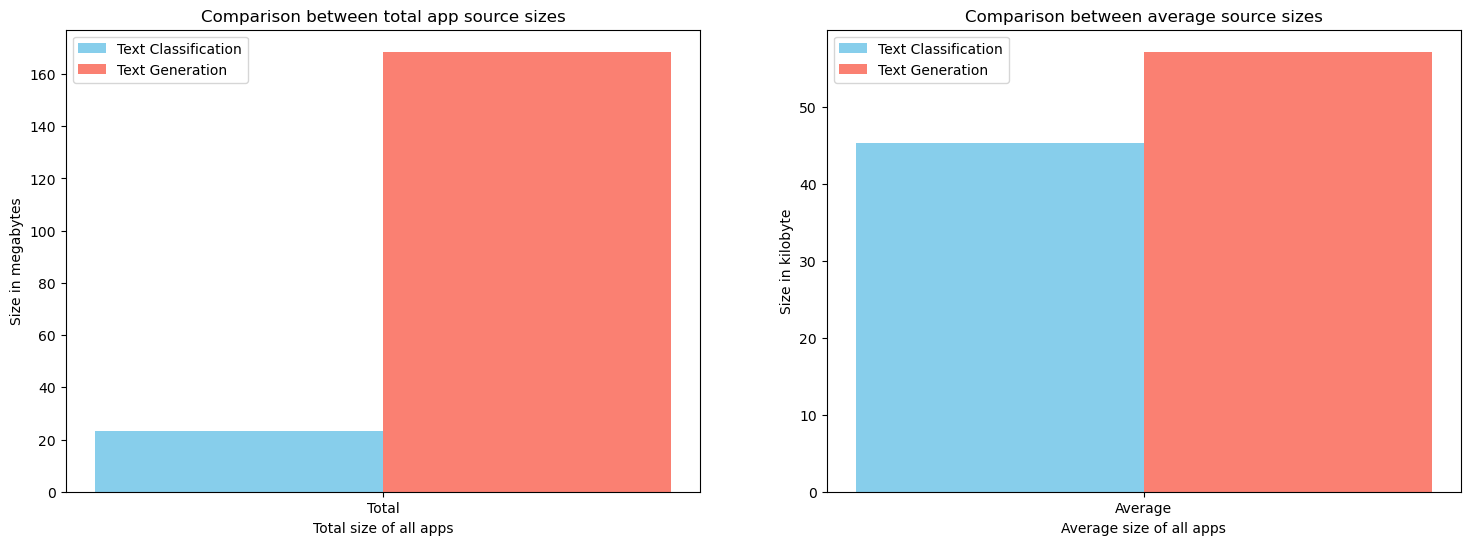

In [43]:
# Create DataFrames
df1 = pd.read_csv("all_csv_data/class_app_source_sizes.csv")
df2 = pd.read_csv("all_csv_data/gen_app_source_sizes.csv")

df1_size=df1['size_in_bytes'].values
df2_size=df2['size_in_bytes'].values

# Set the figure size
plt.figure(figsize=(18, 6))
labels = ['Average']

x = range(len(labels))
width = 0.35

fig, ax =  plt.subplots(1, 2, figsize=(18, 6))
rects1 = ax[0].bar(x, sum(df1_size)/ (1024 * 1024), width, label='Text Classification',color="skyblue")
rects2 = ax[0].bar([i + width for i in x], sum(df2_size)/ (1024 * 1024), width, label='Text Generation',color="salmon")

ax[0].set_xlabel('Total size of all apps')
ax[0].set_ylabel('Size in megabytes')
ax[0].set_title('Comparison between total app source sizes')
ax[0].set_xticks([i + width / 2 for i in x])
ax[0].set_xticklabels(["Total"])
ax[0].legend()


average1 = sum(df1_size) / len(df1_size)
average2 = sum(df2_size) / len(df2_size)

# Example 2: Grouped Bar Chart
# labels = ['Average']

x = range(len(labels))
width = 0.35

# fig, ax = plt.subplots()
rects1 = ax[1].bar(x, average1/1024, width, label='Text Classification',color="skyblue")
rects2 =ax[1].bar([i + width for i in x], average2/1024, width, label='Text Generation',color="salmon")

ax[1].set_xlabel('Average size of all apps')
ax[1].set_ylabel('Size in kilobyte')
ax[1].set_title('Comparison between average source sizes')
ax[1].set_xticks([i + width / 2 for i in x])
ax[1].set_xticklabels(["Average"])
ax[1].legend()
# Show the plot
plt.show()
fig.savefig("plot_imgs/total_avg_source_sizes.png")

# Step 5: Merging all individual obtained value into one CSV for both text classification and text generation models
- First merging step 1 obtaied data with step 2 obtained data using a common field called 'model_name'
- Obtained data from the previous step has all the necessary columns and values from task step 1 and step 2
- finally, will add a new column app_sizes to the previously retained data
- app_sizes will contain list of the app's size in same order as app_list for a individual model

In [36]:
# reusable merging funciton
def merge_csv_into_one(model_csv, app_count_csv, app_source_size_csv):
    models_data= pd.read_csv(model_csv)
    app_count_data=pd.read_csv(app_count_csv)
    app_source_size_csv = pd.read_csv(app_source_size_csv)
    
    # merging step 1 and step 2 data into one
    models_data = pd.merge(models_data,app_count_data, on ='model_name')
    
    # merging previously merged data and step 3
    app_dict = dict(zip(app_source_size_csv['app_name'], app_source_size_csv['size_in_bytes']))

    # Create a function to retrieve app sizes based on the space_list
    def get_app_sizes(space_list):
        space_list=ast.literal_eval(space_list)
        return [app_dict.get(app_name) for app_name in space_list]

    models_data['app_sizes_in_bytes'] = models_data['app_list'].apply(get_app_sizes)
    return models_data

In [37]:
class_data_merged= merge_csv_into_one("all_csv_data/classification_models.csv","all_csv_data/classification_app_count.csv","all_csv_data/class_app_source_sizes.csv")
gen_data_merged = merge_csv_into_one("all_csv_data/generation_models.csv","all_csv_data/generation_app_count.csv","all_csv_data/gen_app_source_sizes.csv")


### First 5 rows of data of text classification csv

In [38]:
class_data_merged.head()

,model_name,model_type,updated,downloaded,liked,model_url,app_list,total_app,app_sizes_in_bytes
0,distilbert-base-uncased-finetuned-sst-2-english,Text Classification,Oct 26,30.7M,355,https://huggingface.co/distilbert-base-uncased...,"['microsoft/HuggingGPT', 'society-ethics/model...",207,"[88343.64, 9619.24, 142854.32, 229976.2, 15153..."
1,cardiffnlp/twitter-roberta-base-irony,Text Classification,Aug 2,6.8M,14,https://huggingface.co/cardiffnlp/twitter-robe...,['Eberhenriquez/cardiffnlp-twitter-roberta-bas...,1,[1927.48]
2,lxyuan/distilbert-base-multilingual-cased-sent...,Text Classification,Jun 24,6.54M,55,https://huggingface.co/lxyuan/distilbert-base-...,['jingwora/language-emotion-classification-sen...,10,"[4370.56, 21825.76, 9136.08, 25861.08, 22069.5..."
3,mrm8488/distilroberta-finetuned-financial-news...,Text Classification,Mar 16,6.54M,123,https://huggingface.co/mrm8488/distilroberta-f...,"['sohomghosh/FLUEnT', 'Anthos23/hummus', 'niko...",14,"[22595.450000000004, 2607.92, 4103.88, 3924.2,..."
4,SamLowe/roberta-base-go_emotions,Text Classification,Oct 4,6.5M,191,https://huggingface.co/SamLowe/roberta-base-go...,['Pontonkid/Real-Time-Multilingual-sentiment-a...,28,"[6954.07, 3583.28, 1888.48, 6157.48, 1917.48, ..."


### First 5 rows of data of text generation csv

In [39]:
gen_data_merged.head()

,model_name,model_type,updated,downloaded,liked,model_url,app_list,total_app,app_sizes_in_bytes
0,gpt2,Text Generation,Jun 30,21.9M,1.52k,https://huggingface.co/gpt2,"['HuggingFaceH4/open_llm_leaderboard', 'micros...",1150,"[19864.64, 88343.64, 3860.82, 60292.2400000000..."
1,distilgpt2,Text Generation,Apr 29,14.7M,275,https://huggingface.co/distilgpt2,"['h2oai/h2ogpt-chatbot', 'multimodalart/mariog...",105,"[20004.52, 9047.16, 18895.64, 180735.34, 16380..."
2,tiiuae/falcon-7b-instruct,Text Generation,Sep 29,7.32M,754,https://huggingface.co/tiiuae/falcon-7b-instruct,"['h2oai/h2ogpt-chatbot', 'h2oai/h2ogpt-chatbot...",188,"[20004.52, 18895.64, 46087.32, 7106.6399999999..."
3,stabilityai/StableBeluga-7B,Text Generation,Aug 29,3.09M,124,https://huggingface.co/stabilityai/StableBelug...,"['HuggingFaceH4/open_llm_leaderboard', 'upstag...",27,"[19864.64, 30901.22, 46087.32, 74241.91, 7100...."
4,davidkim205/komt-mistral-7b-v1,Text Generation,Oct 24,1.45M,5,https://huggingface.co/davidkim205/komt-mistra...,[],0,[]


In [40]:
# saving the merged data into a csv 
class_data_merged.to_csv("all_csv_data/Classification_model_full_data.csv",index=False)
gen_data_merged.to_csv("all_csv_data/Generation_mode_full_data.csv",index=False)

# Analyze results of the previous steps in order to confirm or reject the claim 'it is easier to develop ML applications using "Text Classification" models than applications using "Text Generation" models'
- step 1 : Compare the number of apps available in the space for each type of the model
- step 2 : Comapre the app size and average size for each type of the model
- step 3 : Make a comment based on the previous steps

In [52]:
# loading classification and generation csv files using pandas
classification_info= pd.read_csv("all_csv_data/Classification_model_full_data.csv")
generation_info= pd.read_csv("all_csv_data/Generation_mode_full_data.csv")

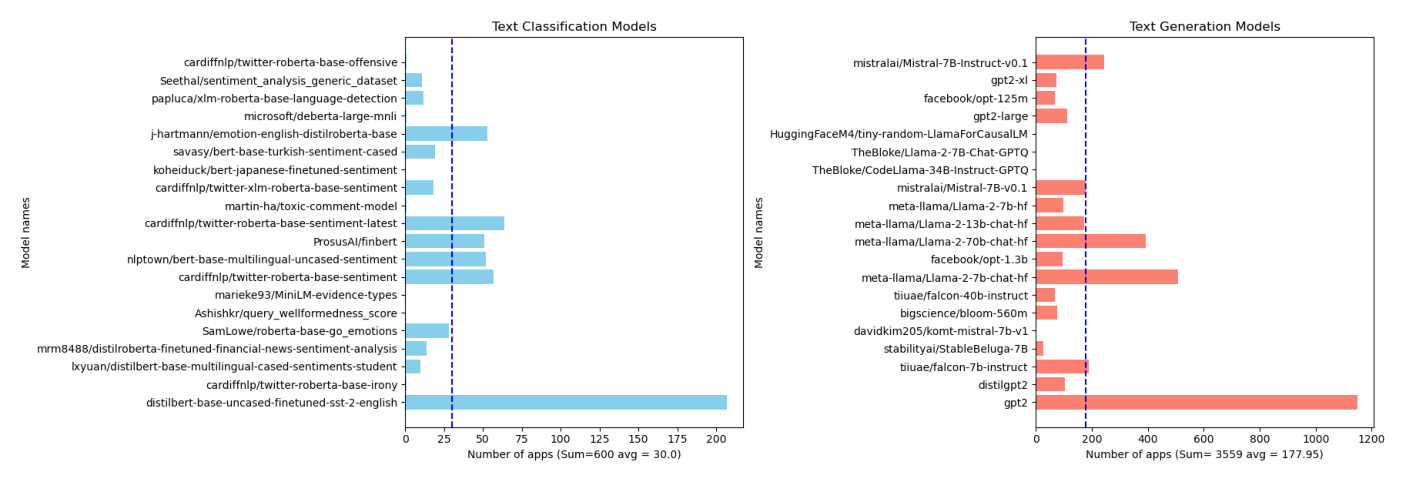

In [50]:
# Load the image using plt.imread()
img = plt.imread('plot_imgs/models_app_count.png') 
plt.figure(figsize=(20, 6))

# Display the image using plt.imshow()
plt.imshow(img)
plt.axis('off') 
plt.show()

The above image shows that:

1. Text Classification Mode
   1. Total app = 600
   1. Average app =30.0
1. Text Generation Model
   1. Total app = 3559
   1. Average app = 177.95



**Difference between the total app** = ( total text generation model apps - total text classification model apps ) = 2959

**Difference between the total app** =(average text generation model apps - Average text classification model apps ) = 147.95

**Text generation models surpass text classification models in total app count, making them the winner in this aspect** 

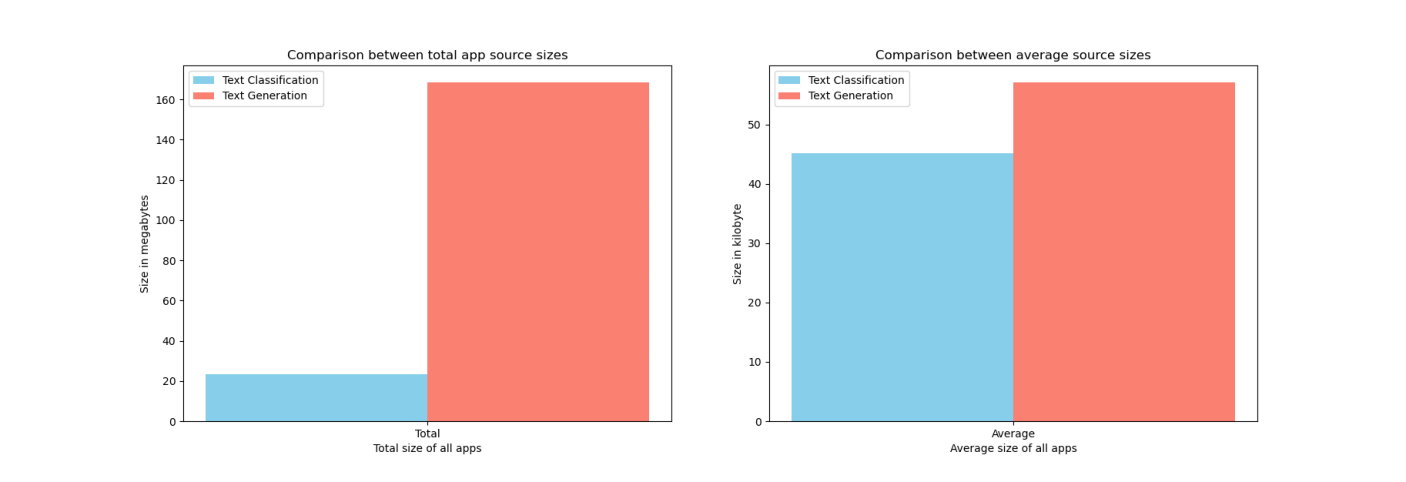

In [53]:
# Load the image using plt.imread()
img = plt.imread('plot_imgs/total_avg_source_sizes.png') 
plt.figure(figsize=(20, 6))

# Display the image using plt.imshow()
plt.imshow(img)
plt.axis('off')
plt.show()

**Above image shows that the text generation models average source code size is a bit higher compare to text classification**

## Step 6: Result of my analysis

Even though the average source code size of text generation models is higher than that of text classification models for ML application development, the number of apps developed for text generation models is significantly greater. That is why I claim that :
### It is easier to develop ML applications using  "Text Generation"  models than applications using "Text Classification" models based on above analysis

# Step 7 : propose further what other analysis could be useful to add

*Despite the higher average source code size, the number of applications developed using text generation models is much higher, indicating that the ease of development may not be solely determined by the source code size.*

There need further other analysis could be useful to add to confirm or reject the claim 'it is easier to develop ML applications using "Text Classification" models than applications using "Text Generation" models.

Some other anlaysis that could be useful to add are as follow :
1. **Training and Inference Resources:** Analyze the computational resources such as CPU time, memory requirements, and training time for both types of models. This will provide insights into the practical aspects of model development and deployment.
2. **Fine-Tuning Requirements:** Quantify the effort required for fine-tuning pre-trained models for "Text Classification" and "Text Generation" tasks. This can provide insights into the adaptability of models to specific domains.
3. **Total time to deploy an app** : The duration needed to deploy an app from the initial stage can indicate which model type is easier to use for developing ML applications.
4. **Developer Surveys and Feedback:** Consider gathering feedback and insights from developers and researchers who have hands-on experience with building and deploying "Text Classification" and "Text Generation" models. This qualitative data can provide valuable perspectives on the ease of development.